# Random Forest Classifier

In [42]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

import matplotlib.pyplot as plt


from dataloader import DataLoader

In [14]:
dataloader = DataLoader('data/loan_data_clean.csv',
                   ['person_income', 'loan_int_rate','loan_percent_income', 'loan_intent'],
                   ['loan_status'])
dataloader.train_test_split(test_size=0.4, random_state=42)

In [15]:
# Define random forest classifier instance
tree = RandomForestClassifier(n_estimators=100,             
                              criterion='gini', 
                              max_depth=None, 
                              min_samples_split=2, 
                              min_samples_leaf=1, 
                              min_weight_fraction_leaf=0.0, 
                              max_features=None,
                              max_leaf_nodes=None, 
                              min_impurity_decrease=0.0, 
                              bootstrap=True, 
                              oob_score=True, 
                              n_jobs=-1,
                              random_state=42, 
                              verbose=1)

# Fit the estimator to the data
tree.fit(dataloader.features_train, np.ravel(dataloader.loan_status_train))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished


RandomForestClassifier(max_features=None, n_jobs=-1, oob_score=True,
                       random_state=42, verbose=1)

## Cross validation 

In [19]:
n_splits = 3
cv_score = cross_val_score(estimator=tree,
                           X=dataloader.features_train,
                           y=np.ravel(dataloader.loan_status_train),
                           scoring='roc_auc',
                           cv=n_splits,
                           n_jobs=-1,
                           verbose=1)
print(cv_score)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent wo

[0.88620881 0.88602302 0.89030362]


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s finished


## Parameter Tuning

The key configuration parameters include the various hyperparameters for the individual decision trees introduced in the notebook [decision_trees](01_decision_trees.ipynb). 

The following tables lists additional options for the two `RandomForest` classes:

| Keyword      | Default | Description                                                                                                                |
|--------------|---------|----------------------------------------------------------------------------------------------------------------------------|
| bootstrap    | True    | Bootstrap samples during training                                                                                          |
| n_estimators | 10      | # trees in the forest.                                                                                                     |
| oob_score    | False   | Use out-of-bag samples to estimate the R2 on unseen data                                                                   |
| warm_start   | False   | Reuse result of previous call to continue training and add more trees to the ensemble, otherwise, train a whole new forest |

- The `bootstrap` parameter activates in the preceding bagging algorithm outline, which in turn enables the computation of the out-of-bag score (oob_score) that estimates the generalization accuracy using samples not included in the bootstrap sample used to train a given tree (see next section for detail). 
- The `n_estimators` parameter defines the number of trees to be grown as part of the forest. Larger forests perform better, but also take more time to build. It is important to monitor the cross-validation error as a function of the number of base learners to identify when the marginal reduction of the prediction error declines and the cost of additional training begins to outweigh the benefits.
- The `max_features` parameter controls the size of the randomly selected feature subsets available when learning a new decision rule and split a node. A lower value reduces the correlation of the trees and, thus, the ensemble's variance, but may also increase the bias. Good starting values are `n_features` (the number of training features) for regression problems and `sqrt(n_features)` for classification problems, but will depend on the relationships among features and should be optimized using cross-validation.

Random forests are designed to contain deep fully-grown trees, which can be created using `max_depth=None` and `min_samples_split=2`. However, these values are not necessarily optimal, especially for high-dimensional data with many samples and, consequently, potentially very deep trees that can become very computationally-, and memory-, intensive.

The `RandomForest` class provided by sklearn support parallel training and prediction by setting the n_jobs parameter to the k number of jobs to run on different cores. The -1 value uses all available cores. The overhead of interprocess communication may limit the speedup from being linear so that k jobs may take more than 1/k the time of a single job. Nonetheless, the speedup is often quite significant for large forests or deep individual trees that may take a meaningful amount of time to train when the data is large, and split evaluation becomes costly.

As always, the best parameter configuration should be identified using cross-validation. The following steps illustrate the process:

### Grid Search Cross Validation

In [34]:
param_grid = {'n_estimators': [50, 100, 250],
              'max_depth': [5, 15, None],
              'min_samples_leaf': [5, 25, 100]}

In [35]:
gridsearch = GridSearchCV(estimator=tree,
                              param_grid=param_grid,
                              scoring='roc_auc',
                              n_jobs=-1,
                              cv=n_splits,
                              refit=True,
                              return_train_score=True,
                              verbose=1)

gridsearch.fit(X=dataloader.features_train, y=np.ravel(dataloader.loan_status_train))

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurr

[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished
[Para

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 250 ou

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(

[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(max_features=None, n_jobs=-1,
                                              oob_score=True, random_state=42,
                                              verbose=1),
             n_jobs=-1,
             param_grid={'max_depth': [5, 15, None],
                         'min_samples_leaf': [5, 25, 100],
                         'n_estimators': [50, 100, 250]},
             return_train_score=True, scoring='roc_auc', verbose=1)

## Feature Importance

A random forest ensemble may contain hundreds of individual trees, but it is still possible to obtain an overall summary measure of feature importance from bagged models.

For a given feature, the importance score is the total reduction in the objective function's value, which results from splits based on this feature, averaged over all trees. Since the objective function takes into account how many features are affected by a split, this measure is implicitly a weighted average so that features used near the top of a tree will get higher scores due to the larger number of observations contained in the much smaller number of available nodes. By averaging over many trees grown in a randomized fashion, the feature importance estimate loses some variance and becomes more accurate.

The computation differs for classification and regression trees based on the different objectives used to learn the decision rules and is measured in terms of the mean square error for regression trees and the Gini index or entropy for classification trees.

`sklearn` further normalizes the feature-importance measure so that it sums up to 1. Feature importance thus computed is also used for feature selection as an alternative to the mutual information measures we saw in Chapter 6, The Machine Learning Process (see SelectFromModel in the sklearn.feature_selection module).
In our example, the importance values for the top-20 features are as shown here:

In [38]:
# Get feature importances
feature_importances = gridsearch.best_estimator_.feature_importances_

In [39]:
# Plot the feature importances
idx = [col.replace('_', ' ').upper() for col in dataloader.features.columns]

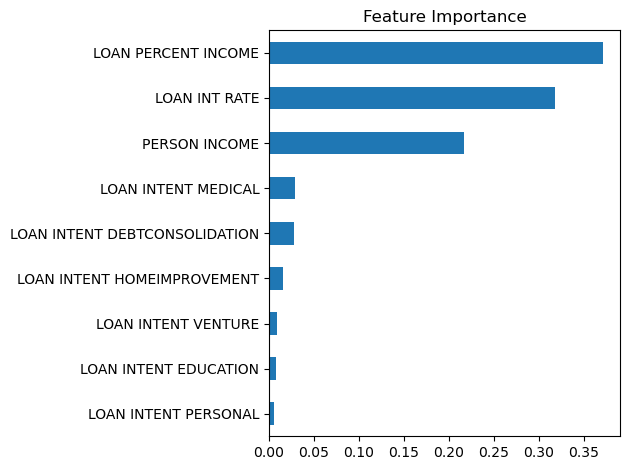

In [59]:
fig, axis = plt.subplots()
(pd.Series(feature_importances, index = idx)
 .sort_values(ascending=True)
 .plot.barh(ax=axis, title='Feature Importance')
)
fig.tight_layout()